In [1]:
import numpy as np
import scipy.sparse as sp
import scipy
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline
import cmath
from qiskit.quantum_info import SparsePauliOp,Pauli
import pandas as pd
import time

## Hamiltonian

In [2]:
n_qubits=8
J=1
h=1
# Construction
X=[]
ZZ=[]
M=[]
for i in range(n_qubits):
    # Hamiltonian
    sx=["I"]*n_qubits
    szz=["I"]*n_qubits
    i1= (i+1)%n_qubits #periodic index
    sx[i]="X"
    szz[i]="Z"
    szz[i1]="Z"
    X.append(Pauli(''.join(sx)).to_matrix(sparse=True))
    ZZ.append(Pauli(''.join(szz)).to_matrix(sparse=True))
    #Magnetization
    mag=["I"]*n_qubits
    mag[i]="Z"
    M.append(Pauli(''.join(mag)).to_matrix(sparse=True))
    
H = sp.csc_matrix(J*np.sum(ZZ,axis=0) + h*np.sum(X,axis=0))
EH,vh=np.linalg.eigh(H.todense())
E_gs=EH[0]
psi_gs=vh[:,0]
print('Energia GS:',E_gs)

Energia GS: -10.251661790966027


## Hamiltonian in pieces of locality T=2

In [3]:
T=2
H_T2=[]
for i in range(n_qubits):
    H_T2.append(J*(ZZ[i])+h/2*(X[i]+X[(i+1)%n_qubits]))

## Pauli Strings general D

In [22]:
D=4
from itertools import product
num_paulis=int(4**D)
print("The number of Paulis is ",num_paulis)
PD = [[0 for i in range(num_paulis)] for j in range(n_qubits)]
if T>D:
    print("Your domain is to small for your Trotterization")
else:
    #displacement of initial qubit in which we compute expectation of Pauli string (if T=D no displacement, if D>T odd centered with gravity towards right, if D>T even centered)
    disp=np.floor(D/T).astype(int)-1
    for j in range(n_qubits):
        i=0
        for qi in product('IXYZ',repeat=D):
            s=["I"]*n_qubits
            for k in range(D):
                ind=(j+k-disp)%n_qubits
                s[ind]=qi[k]
            pstr=''.join(s)
            #print(plist)
            PD[j][i]=sp.csc_matrix(Pauli(pstr).to_matrix(sparse=True))
            i=i+1
        #print(i,num_paulis)

The number of Paulis is  256


# Exact ITE and classical QITE

In [18]:
#Initial state and duration
dt=0.25
N=8+1
t=0 + np.arange(0, N) *dt
psi_0 = np.zeros((2**n_qubits,1),dtype=complex)
psi_0[0] = 1
psi_0 = sp.csc_matrix(psi_0/scipy.linalg.norm(psi_0))

In [19]:
# Exact evolution
tmax=dt*(N-1)
t_ITE=np.linspace(0,tmax,num=50)
EITE=np.zeros(len(t_ITE),dtype=complex)
for i in range(len(t_ITE)):
    phi=sp.linalg.expm_multiply(-H*t_ITE[i],psi_0)
    psiITE=phi/sp.linalg.norm(phi)
    EITE[i]=np.real((psiITE.T@H@psiITE).trace())

In [23]:
start_time = time.time()
psi_QITE=psi_0
a=np.zeros((N,n_qubits,num_paulis),dtype=complex)
E_QITED=np.zeros(N)
E_QITED[0]=np.real((psi_QITE.T@H@psi_QITE).trace())
F=np.zeros(N)
F[0] = np.real((psi_QITE.getH()@psi_gs)[0,0])**2
for i in range(0,N-1):
    #ara en aquest pas de temps anem a calcular els coeffs per a cada qubit
    for l in range(n_qubits):
        #print('Time step',i+1,'/',N-1,'acting on qubit',l)
        #computing matrix S and coeffcient b (steps 1-3 in the algorithm)
        X=sp.csc_matrix((2**n_qubits,num_paulis),dtype=complex)
        b=np.zeros((num_paulis),dtype=complex)
        aux=np.real((psi_QITE.getH()@sp.linalg.expm_multiply(-2*H_T2[l]*dt,psi_QITE)).trace())
        c=cmath.sqrt(aux)
        expHdt=sp.linalg.expm(-H_T2[l]*dt)
        for j in range(num_paulis):
            b[j] = -1j*(psi_QITE.getH()@(expHdt@PD[l][j]-PD[l][j]@expHdt)@psi_QITE).trace()/c/dt
            X[:,j]=PD[l][j]*psi_QITE
        S=(X.getH()@X).todense()
        
        #least square solution of equation (S+S^T)*a = b (step 4 in algorithm)
        a[i,l]=(scipy.linalg.lstsq(S+S.T,b,lapack_driver='gelsy'))[0]
        
        #construction of the evolution operator (steps 5 and 6 in the algorithm)
        operator=sp.lil_matrix((2**n_qubits,2**n_qubits),dtype=complex)
        for j in range(num_paulis):
            operator+=a[i,l,j]*PD[l][j]
        psi_QITE = sp.linalg.expm(-1j*operator*dt)@psi_QITE
        
    #Enegy and fidelity of the state at time step i
    E_QITED[i+1] = np.real((psi_QITE.getH()@H@psi_QITE).trace())
    F[i+1] = np.real((psi_QITE.getH()@psi_gs)[0,0])**2
    print("--- %s seconds ---" % (time.time() - start_time))s

--- 5.198090076446533 seconds ---
--- 10.969964981079102 seconds ---
--- 16.889766216278076 seconds ---
--- 22.599586486816406 seconds ---
--- 28.22859835624695 seconds ---
--- 34.24853777885437 seconds ---
--- 40.00020432472229 seconds ---
--- 45.66547131538391 seconds ---


In [24]:
F4=F
E4=E_QITED

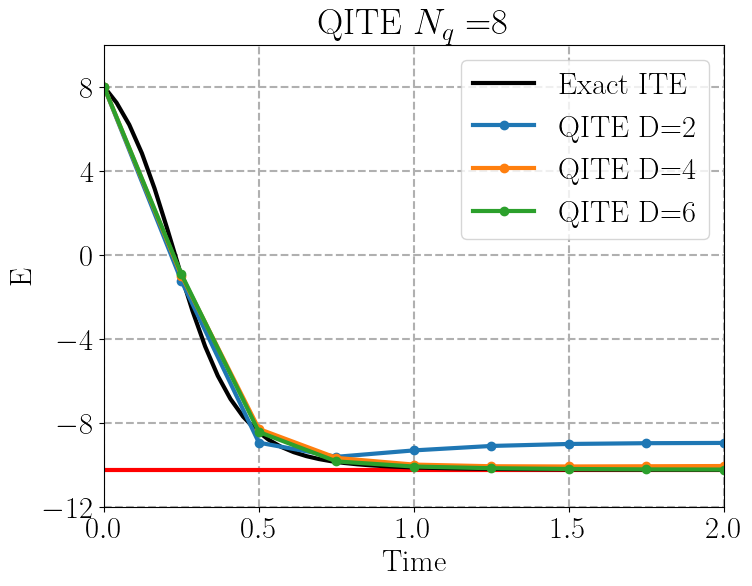

In [28]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({
    "text.usetex": True,
})
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.plot(t,np.zeros(N)+np.real(E_gs),'-r',linewidth=3)
plt.plot(t_ITE,np.real(EITE),'-k',linewidth=3,label='Exact ITE')
plt.plot(t,np.real(E2),'-o',linewidth=3,label='QITE D=%d'%2)
plt.plot(t,np.real(E4),'-o',linewidth=3,label='QITE D=%d'%4)
plt.plot(t,np.real(E6),'-o',linewidth=3,label='QITE D=%d'%6)
plt.xlabel("Time")
plt.ylabel("E")
plt.title("QITE $N_q=$%d"%n_qubits)
plt.xlim(0, (N-1)*dt)
plt.ylim([-12,10])
plt.yticks(np.arange(-12, 10, step=4))
#plt.ylim(np.floor(np.real(E_gs)), -np.floor(np.real(E_gs)))
plt.legend()
plt.grid(linestyle = '--', linewidth = 1.5)
plt.savefig('paper/qite_TFIM_N8.png')

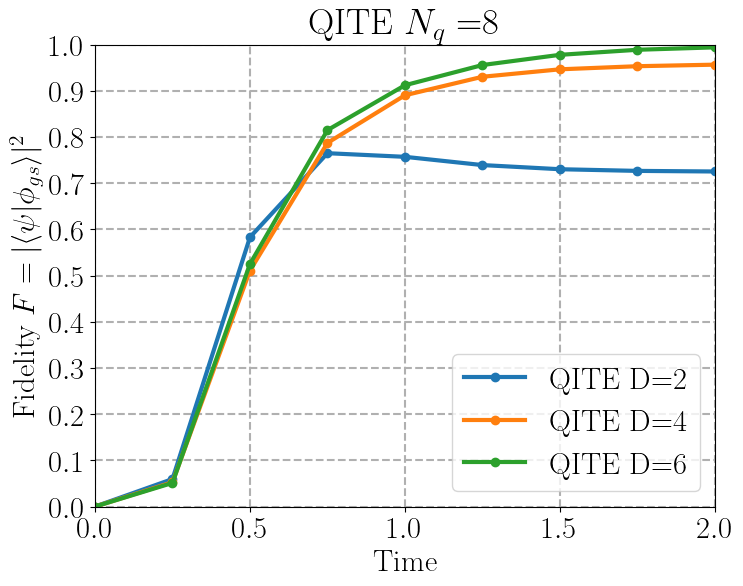

In [31]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({
    "text.usetex": True,
})
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.plot(t,np.real(F2),'-o',linewidth=3,label='QITE D=%d'%2)
plt.plot(t,np.real(F4),'-o',linewidth=3,label='QITE D=%d'%4)
plt.plot(t,np.real(F6),'-o',linewidth=3,label='QITE D=%d'%6)
plt.xlabel("Time")
plt.ylabel("Fidelity $F=|\\langle \\psi|\\phi_{gs}\\rangle|^2$")
plt.title("QITE $N_q=$%d"%n_qubits)
plt.xlim(0, (N-1)*dt)
plt.ylim([0,1])
plt.yticks(np.arange(0, 1.1, step=0.1))
#plt.ylim(np.floor(np.real(E_gs)), -np.floor(np.real(E_gs)))
plt.legend()
plt.grid(linestyle = '--', linewidth = 1.5)
plt.savefig('paper/qite_TFIM_F_N8.png')

In [8]:
import scipy.io as sio

savedict = {
    'N' : n_qubits,
    'D' : D,
    'T' : T,
    'a' : a,
    'psi0' : psi_0,
    'psiQITE' : psi_QITE,
    'J' : J,
    'h' : h,
    't' : t,
    'E_qite' : E_QITED,
    'Fid': F,
}

sio.savemat('qite_paper_N%d_D%d_altres.mat'%(n_qubits,D), savedict)